In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
def process(path):
    fs = 2.9296875e6
    NFFT = 2**20
    T = NFFT/fs*30
    x = np.fromfile(path, dtype='float32').reshape((-1, 2**20))
    y = np.average(x, axis=0)
    y[NFFT//2] = 0
    a = np.argmax(y)
    plt.figure()
    y[NFFT//2] = np.nan
    f = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))
    plt.plot(f * 1e-6, y)
    plt.title('Spectrum')
    plt.ylabel('PSD (linear units)')
    plt.xlabel('Baseband frequency (MHz)')
    width = 50
    plt.figure()
    plt.imshow(x[:, a-width:a+width], aspect='auto',
               extent=[f[a-width], f[a+width], x.shape[0]*T, 0])
    plt.title('Carrier waterfall')
    plt.ylabel('Time since recording start (s)')
    plt.xlabel('Baseband frequency (Hz)')
    sigbins = 3
    b = np.argmax(x[:, a-width:a+width], axis=1) + a - width
    sig = np.array([y[c-sigbins:c+sigbins+1] for c, y in zip(b, x)])
    noise_bins = 200
    noise = np.array([np.concatenate((y[c-noise_bins-2*sigbins:c-2*sigbins],
                                      y[c+2*sigbins+1:c+noise_bins+2*sigbins+1]))
                      for c, y in zip(b, x)])
    plt.figure()
    plt.plot(sig.T, color='C0')
    plt.title('Aligned carrier spectrum')
    plt.ylabel('PSD (linear units)')
    plt.xlabel('FFT bin')
    plt.figure()
    plt.plot(noise.T, color='C0')
    plt.title('Noise spectrum')
    plt.ylabel('PSD (linear units)')
    plt.xlabel('FFT bin')
    sig_pwr_t = np.sum(sig, axis=1)
    noise_pwr_t = np.average(noise, axis=1)
    sig_pwr_t -= noise_pwr_t*sig.shape[1]
    plt.figure()
    t = np.arange(sig_pwr_t.shape[0])*T
    plt.plot(t, 10*np.log10(sig_pwr_t) - 124.5)
    plt.plot(t, 10*np.log10(noise_pwr_t) - 105)
    plt.legend(['Signal power (minus 124.5 dB)', 'Noise power per bin (minus 105 dB)'])
    plt.title('Signal and noise power versus time')
    plt.xlabel('Time since recording start (s)')
    plt.ylabel('Power (dB)')
    sig_pwr = np.average(np.sum(sig, axis = 1))
    noise_pwr = np.average(noise)
    sig_pwr -= noise_pwr*sig.shape[1]
    print(f'Carrier power {10*np.log10(sig_pwr):.2f} dB')
    print(f'Noise power per bin {10*np.log10(noise_pwr):.2f} dB')
    snr = sig_pwr / noise_pwr
    cn0_dB = 10*np.log10(snr * fs / NFFT)
    print(f'Carrier CN0 {cn0_dB:.2f} dB')
    sb_idx = round(22.5e3/fs*NFFT)
    width = 300
    sb_right = x[:, a+sb_idx-width:a+sb_idx+width]
    sb_left = x[:, a-sb_idx-width:a-sb_idx+width]
    plt.figure()
    plt.imshow(sb_right, aspect='auto',
               extent=[f[a+sb_idx-width], f[a+sb_idx+width], x.shape[0]*T, 0])
    plt.title('Right sideband waterfall')
    plt.ylabel('Time since recording start (s)')
    plt.xlabel('Baseband frequency (Hz)')
    plt.figure()
    plt.imshow(sb_left, aspect='auto',
               extent=[f[a-sb_idx-width], f[a-sb_idx+width], x.shape[0]*T, 0])
    plt.title('Left sideband waterfall')
    plt.ylabel('Time since recording start (s)')
    plt.xlabel('Baseband frequency (Hz)')
    sb_pwr_right = np.average(np.sum(sb_right, axis = 1))
    sb_pwr_left = np.average(np.sum(sb_left, axis = 1))
    sb_pwr_right -= noise_pwr*sb_right.shape[1]
    sb_pwr_left -= noise_pwr*sb_left.shape[1]
    sb_pwr_total = sb_pwr_left + sb_pwr_right
    print(f'Sideband power {10*np.log10(sb_pwr_right):.2f} dB (right) '
          f'{10*np.log10(sb_pwr_left):.2f} dB (left) '
          f'{10*np.log10(sb_pwr_total):.2f} dB (total)')
    snr_sb = sb_pwr_total / noise_pwr
    cn0_sb_dB = 10*np.log10(snr_sb * fs / NFFT)
    print(f'Sideband CN0 {cn0_sb_dB:.2f} dB (counting both sidebands)')
    bitrate = 160
    print(f'Data EbN0 {cn0_sb_dB - 10*np.log10(bitrate):.2f} dB')

Carrier power 124.41 dB
Noise power per bin 105.13 dB
Carrier CN0 23.74 dB
Sideband power 126.03 dB (right) 126.02 dB (left) 129.04 dB (total)
Sideband CN0 28.37 dB (counting both sidebands)
Data EbN0 6.33 dB


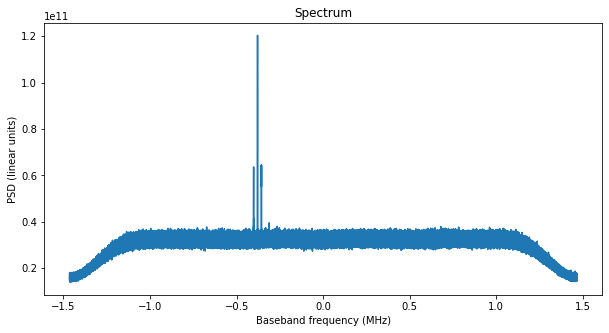

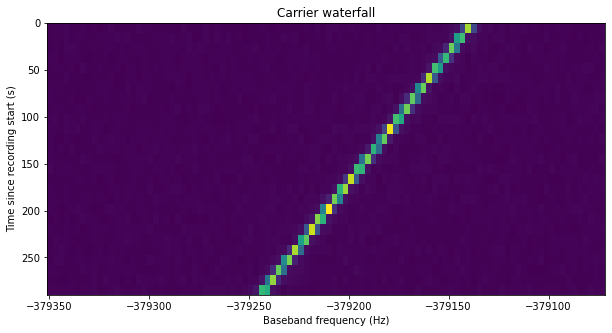

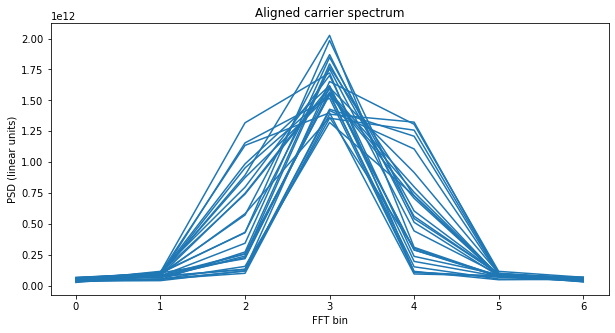

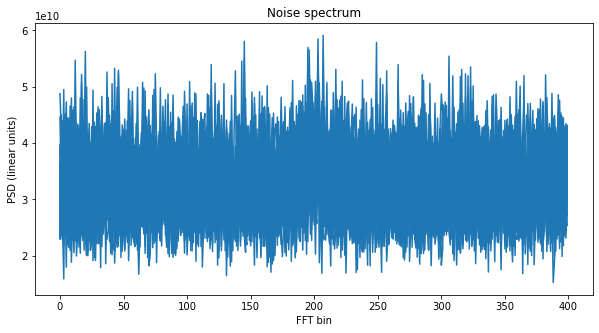

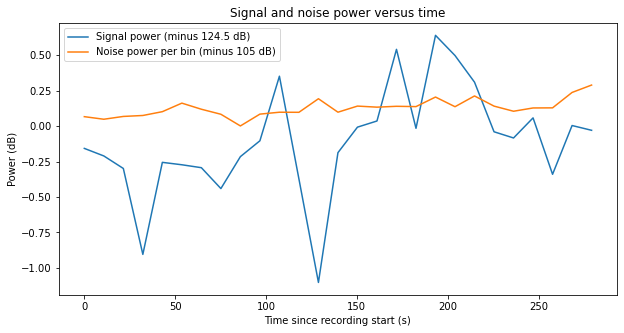

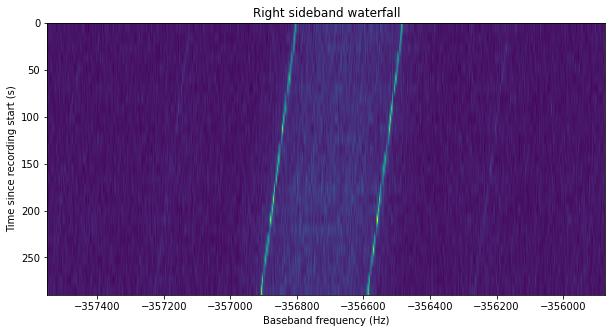

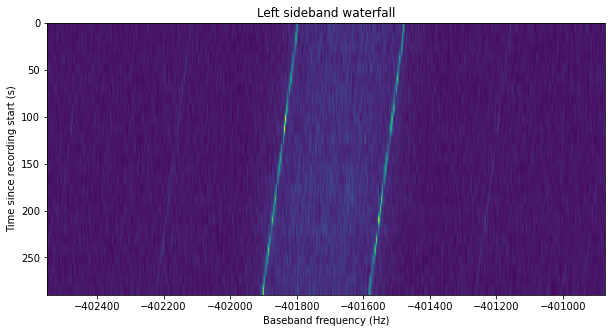

In [3]:
process('2020/spectrum_0011.f32')

/tmp/ipykernel_1795/360450539.py:45: RuntimeWarning: invalid value encountered in log10
  plt.plot(t, 10*np.log10(sig_pwr_t) - 124.5)


Carrier power 105.78 dB
Noise power per bin 108.28 dB
Carrier CN0 1.97 dB
Sideband power 102.09 dB (right) 108.35 dB (left) 109.27 dB (total)
Sideband CN0 5.46 dB (counting both sidebands)
Data EbN0 -16.58 dB


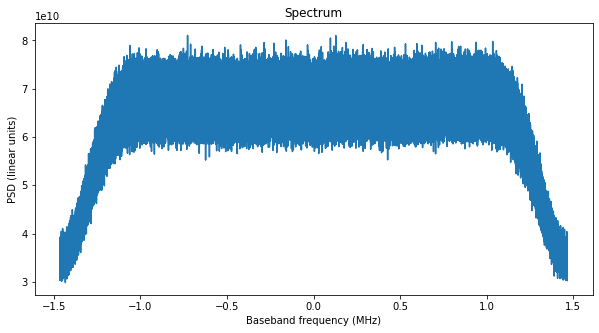

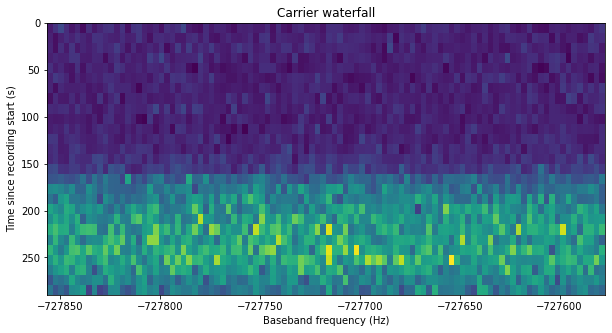

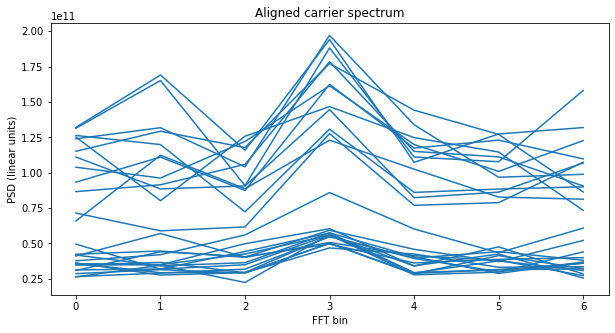

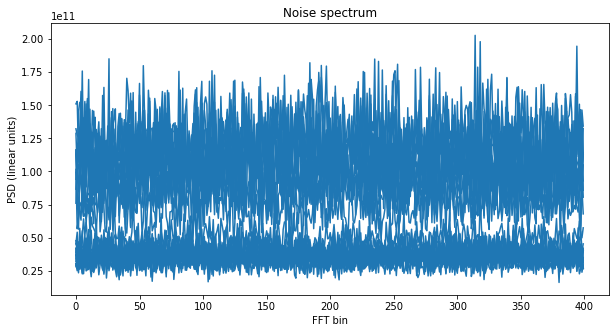

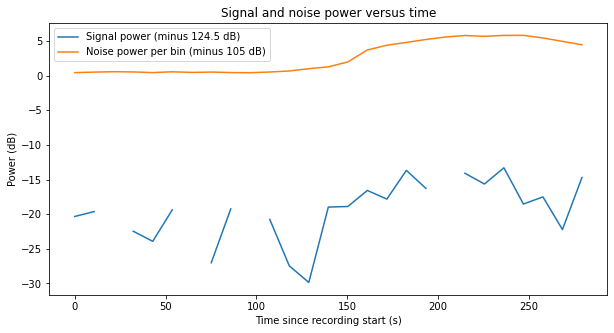

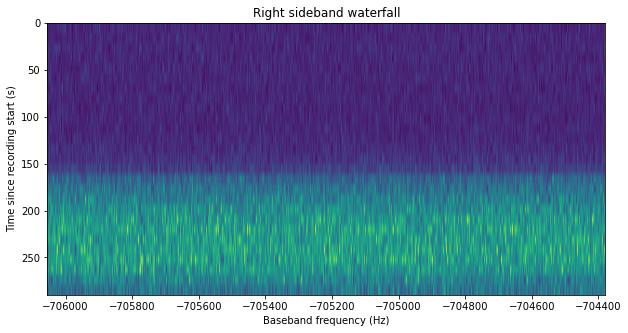

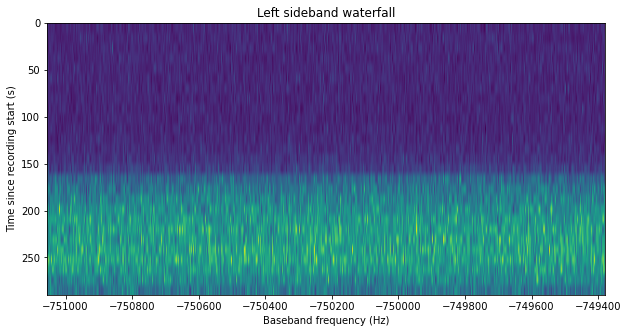

In [4]:
process('2020/spectrum_0012.f32')

Carrier power 123.90 dB
Noise power per bin 107.88 dB
Carrier CN0 20.49 dB
Sideband power 125.55 dB (right) 125.61 dB (left) 128.59 dB (total)
Sideband CN0 25.17 dB (counting both sidebands)
Data EbN0 3.13 dB


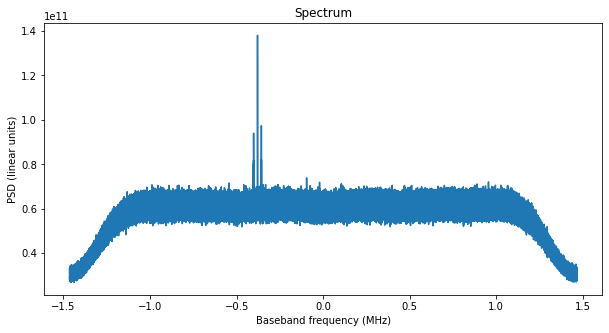

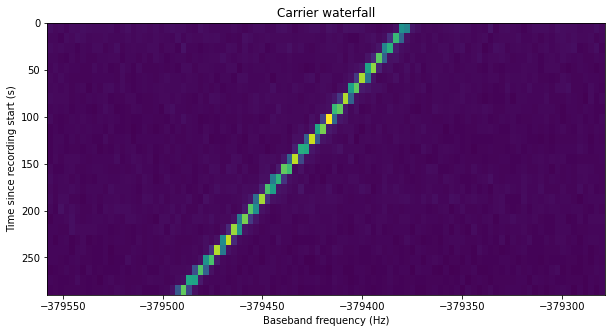

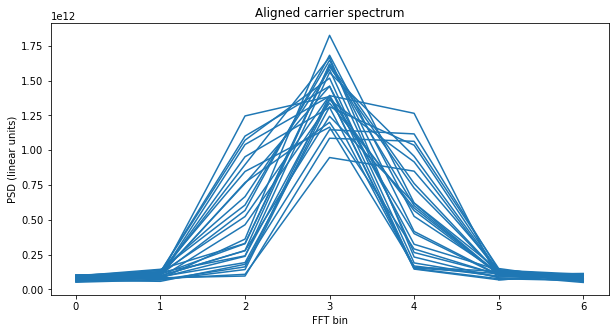

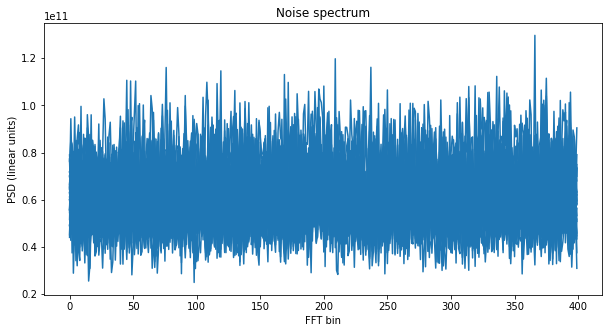

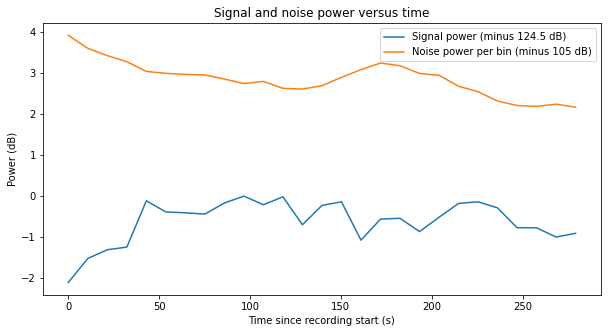

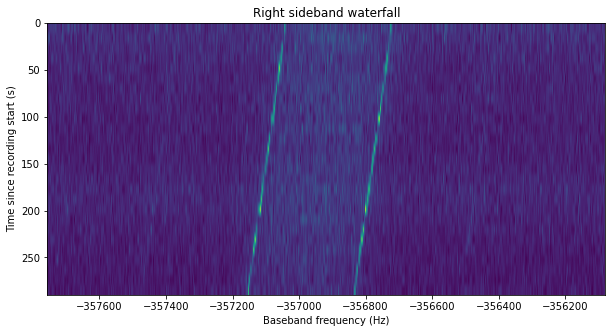

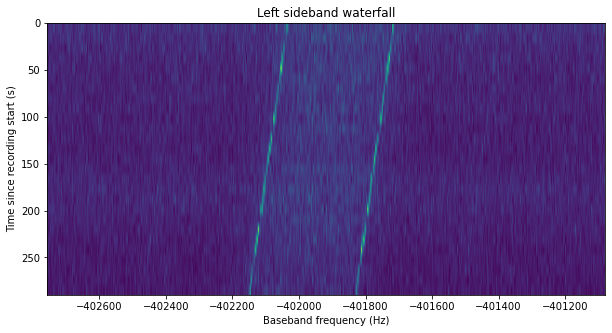

In [5]:
process('2020/spectrum_0013.f32')

/tmp/ipykernel_1795/360450539.py:45: RuntimeWarning: invalid value encountered in log10
  plt.plot(t, 10*np.log10(sig_pwr_t) - 124.5)
/tmp/ipykernel_1795/360450539.py:80: RuntimeWarning: invalid value encountered in log10
  print(f'Sideband power {10*np.log10(sb_pwr_right):.2f} dB (right) '
/tmp/ipykernel_1795/360450539.py:81: RuntimeWarning: invalid value encountered in log10
  f'{10*np.log10(sb_pwr_left):.2f} dB (left) '
/tmp/ipykernel_1795/360450539.py:82: RuntimeWarning: invalid value encountered in log10
  f'{10*np.log10(sb_pwr_total):.2f} dB (total)')
/tmp/ipykernel_1795/360450539.py:84: RuntimeWarning: invalid value encountered in log10
  cn0_sb_dB = 10*np.log10(snr_sb * fs / NFFT)


Carrier power 103.64 dB
Noise power per bin 106.58 dB
Carrier CN0 1.52 dB
Sideband power nan dB (right) nan dB (left) nan dB (total)
Sideband CN0 nan dB (counting both sidebands)
Data EbN0 nan dB


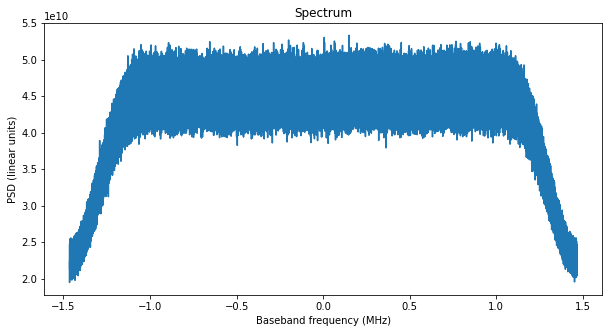

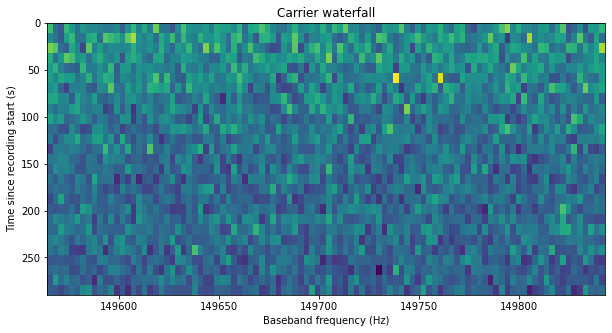

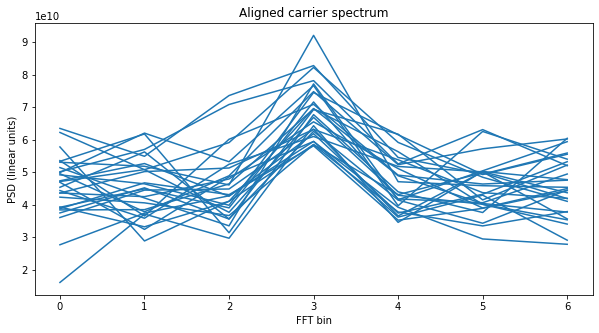

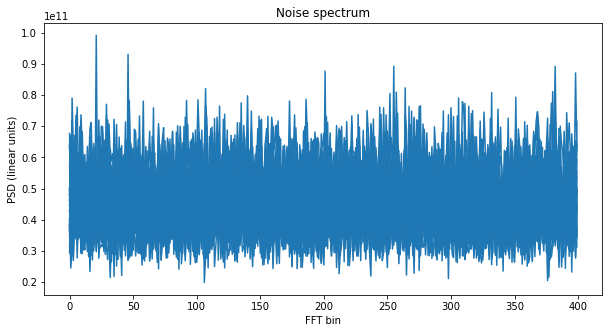

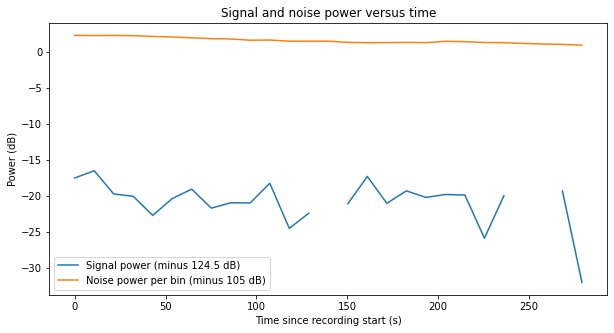

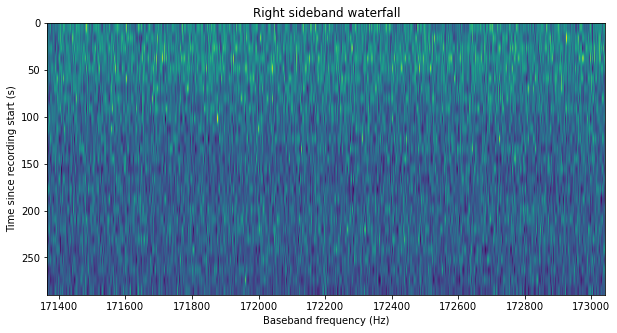

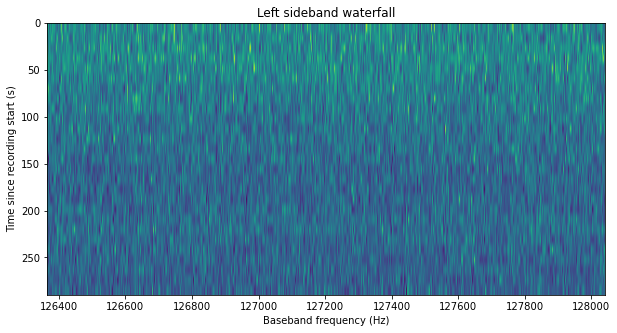

In [6]:
process('2020/spectrum_0014.f32')

Carrier power 124.26 dB
Noise power per bin 105.51 dB
Carrier CN0 23.21 dB
Sideband power 125.99 dB (right) 125.96 dB (left) 128.99 dB (total)
Sideband CN0 27.94 dB (counting both sidebands)
Data EbN0 5.90 dB


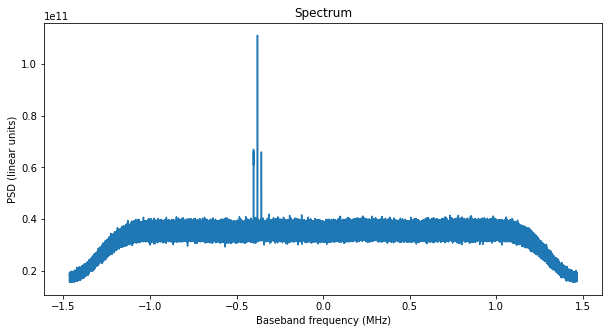

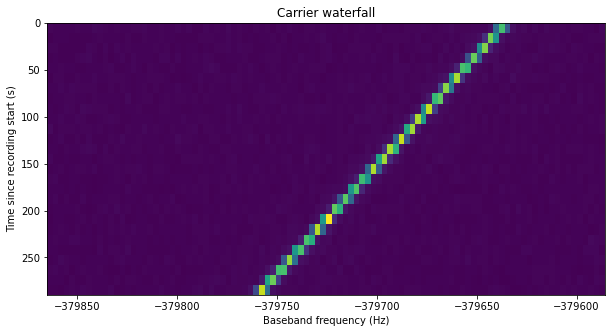

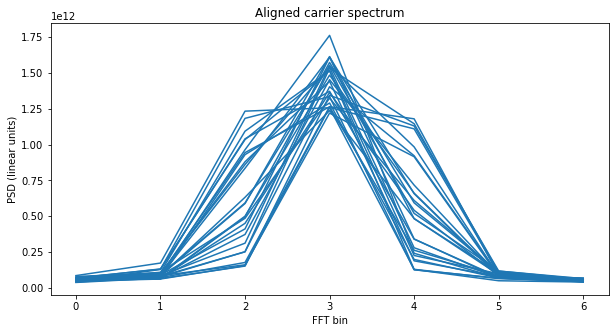

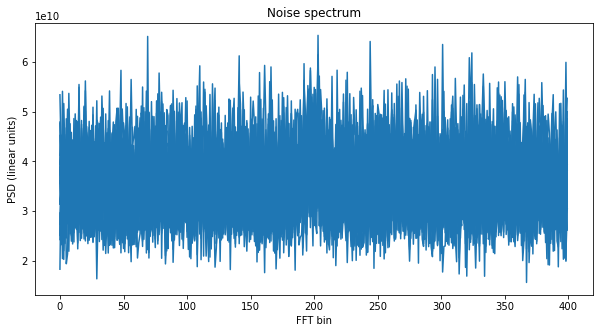

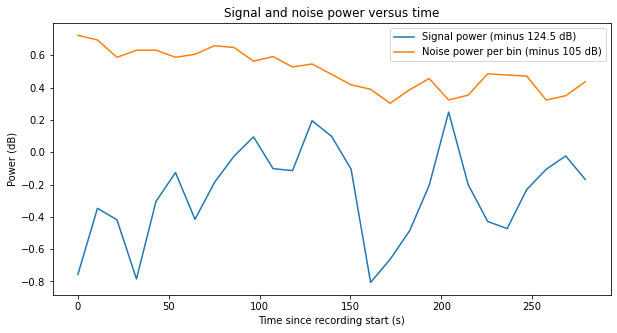

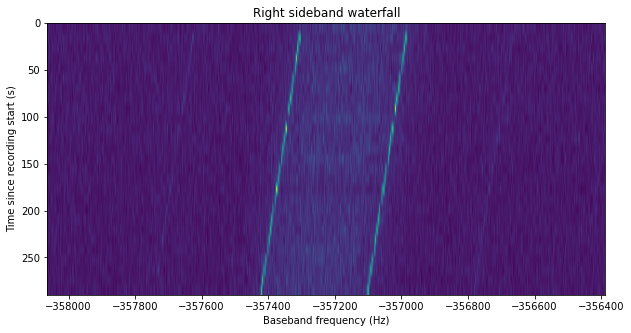

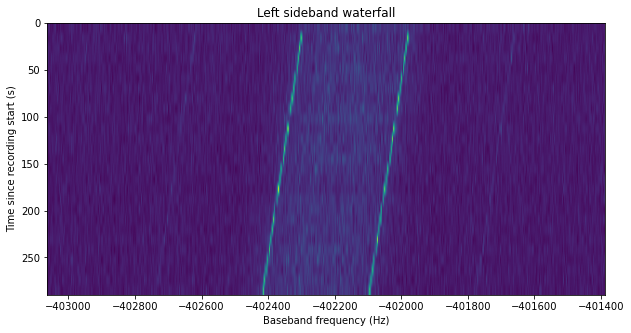

In [7]:
process('2020/spectrum_0015.f32')

/tmp/ipykernel_1795/360450539.py:45: RuntimeWarning: invalid value encountered in log10
  plt.plot(t, 10*np.log10(sig_pwr_t) - 124.5)
/tmp/ipykernel_1795/360450539.py:80: RuntimeWarning: invalid value encountered in log10
  print(f'Sideband power {10*np.log10(sb_pwr_right):.2f} dB (right) '
/tmp/ipykernel_1795/360450539.py:81: RuntimeWarning: invalid value encountered in log10
  f'{10*np.log10(sb_pwr_left):.2f} dB (left) '
/tmp/ipykernel_1795/360450539.py:82: RuntimeWarning: invalid value encountered in log10
  f'{10*np.log10(sb_pwr_total):.2f} dB (total)')
/tmp/ipykernel_1795/360450539.py:84: RuntimeWarning: invalid value encountered in log10
  cn0_sb_dB = 10*np.log10(snr_sb * fs / NFFT)


Carrier power 101.55 dB
Noise power per bin 105.00 dB
Carrier CN0 1.02 dB
Sideband power nan dB (right) nan dB (left) nan dB (total)
Sideband CN0 nan dB (counting both sidebands)
Data EbN0 nan dB


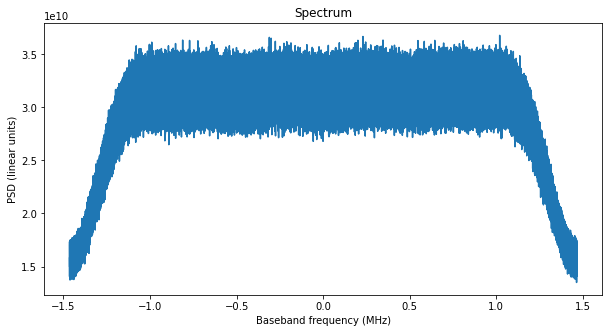

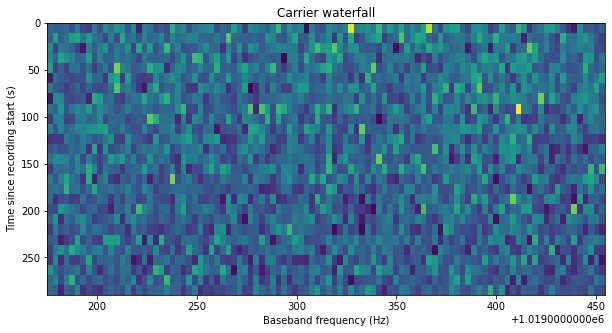

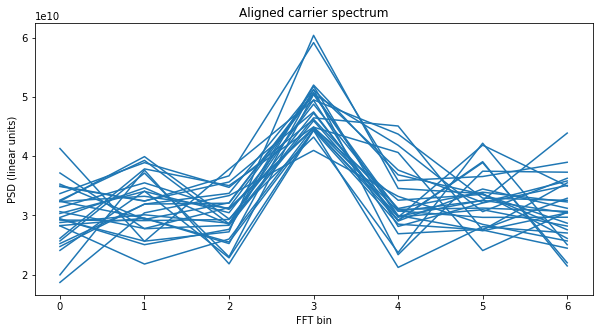

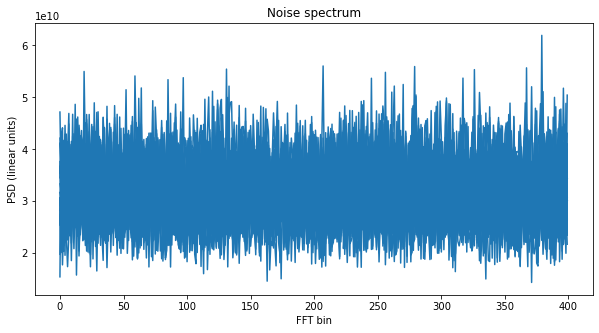

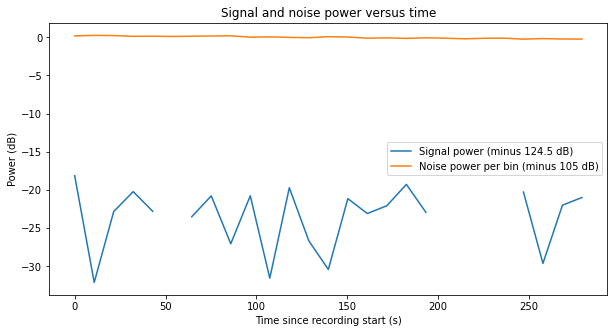

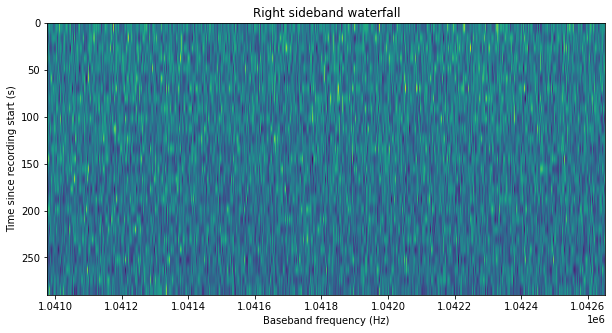

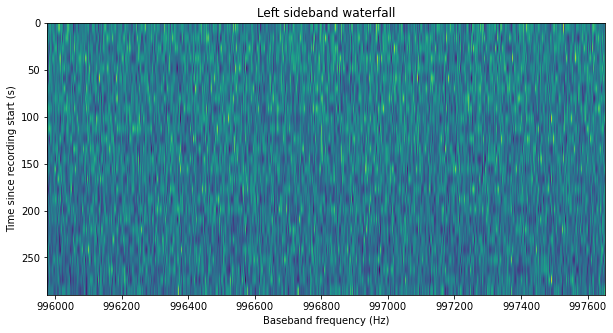

In [8]:
process('2020/spectrum_0016.f32')